# Contextual Bandits Agent with Policy Gradient Method (Deterministic) in Prediction Markets Problem
---
This is a program that simulates an agent who trades in a prediction market. The problem that the prediction market aims to solve is to predict the real distribution of a random variable. We define the random variable as the colour of a bucket. The problem design comes from a human-subjective experiment for decision markets.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from main import deterministic_training_notebook
from Environment import DecisionRule

In [18]:
feature_num = 3
action_num = 2
learning_rate_theta = 1e-4
decay_rate = 0  # 0.001
learning_rate_wv = 3e-3
learning_rate_wq = 1e-2
memory_size = 16
batch_size = 16
training_episodes = 900000
beta1 = 0.9
beta2 = 0.9999
fixed_std = 0.3
# Algorithm: adam, momentum, regular
algorithm = 'regular'
# Bucket parameters
prior_red_list = [3 / 4, 1 / 4]
pr_red_ball_red_bucket = 2 / 3
pr_red_ball_blue_bucket = 1 / 3
agent_num = 1

explorer_learning = False
decision_rule = DecisionRule.STOCHASTIC
preferred_colour_pr_list = [0.8, 0.2]

agent_list = deterministic_training_notebook(feature_num, action_num, learning_rate_theta, learning_rate_wv, learning_rate_wq,
                                             memory_size, batch_size, training_episodes,
                                             decay_rate, beta1, beta2, algorithm, pr_red_ball_red_bucket,
                                             pr_red_ball_blue_bucket, prior_red_list, agent_num,
                                             explorer_learning, fixed_std, decision_rule, preferred_colour_pr_list)

  0%|          | 0/900000 [00:00<?, ?it/s]

agent0
learning_rate_theta= 0.0001
learning_rate_wv= 0.003  learning_rate_wq= 0.01
memory_size= 16
Updating weights with regular algorithm.


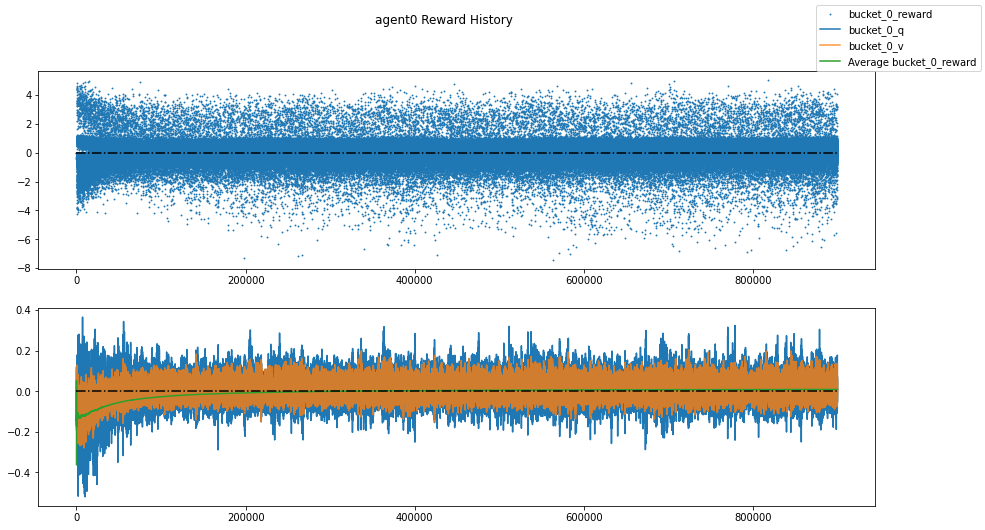

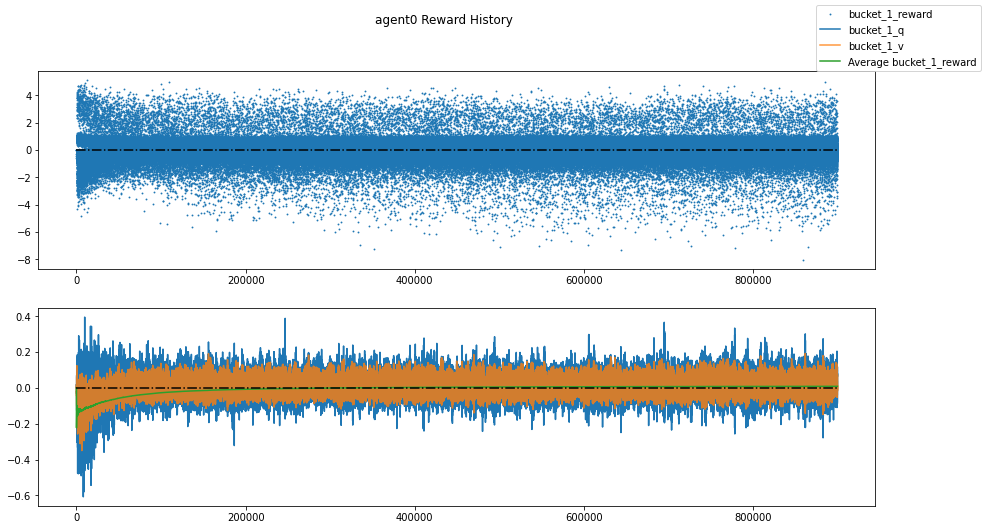

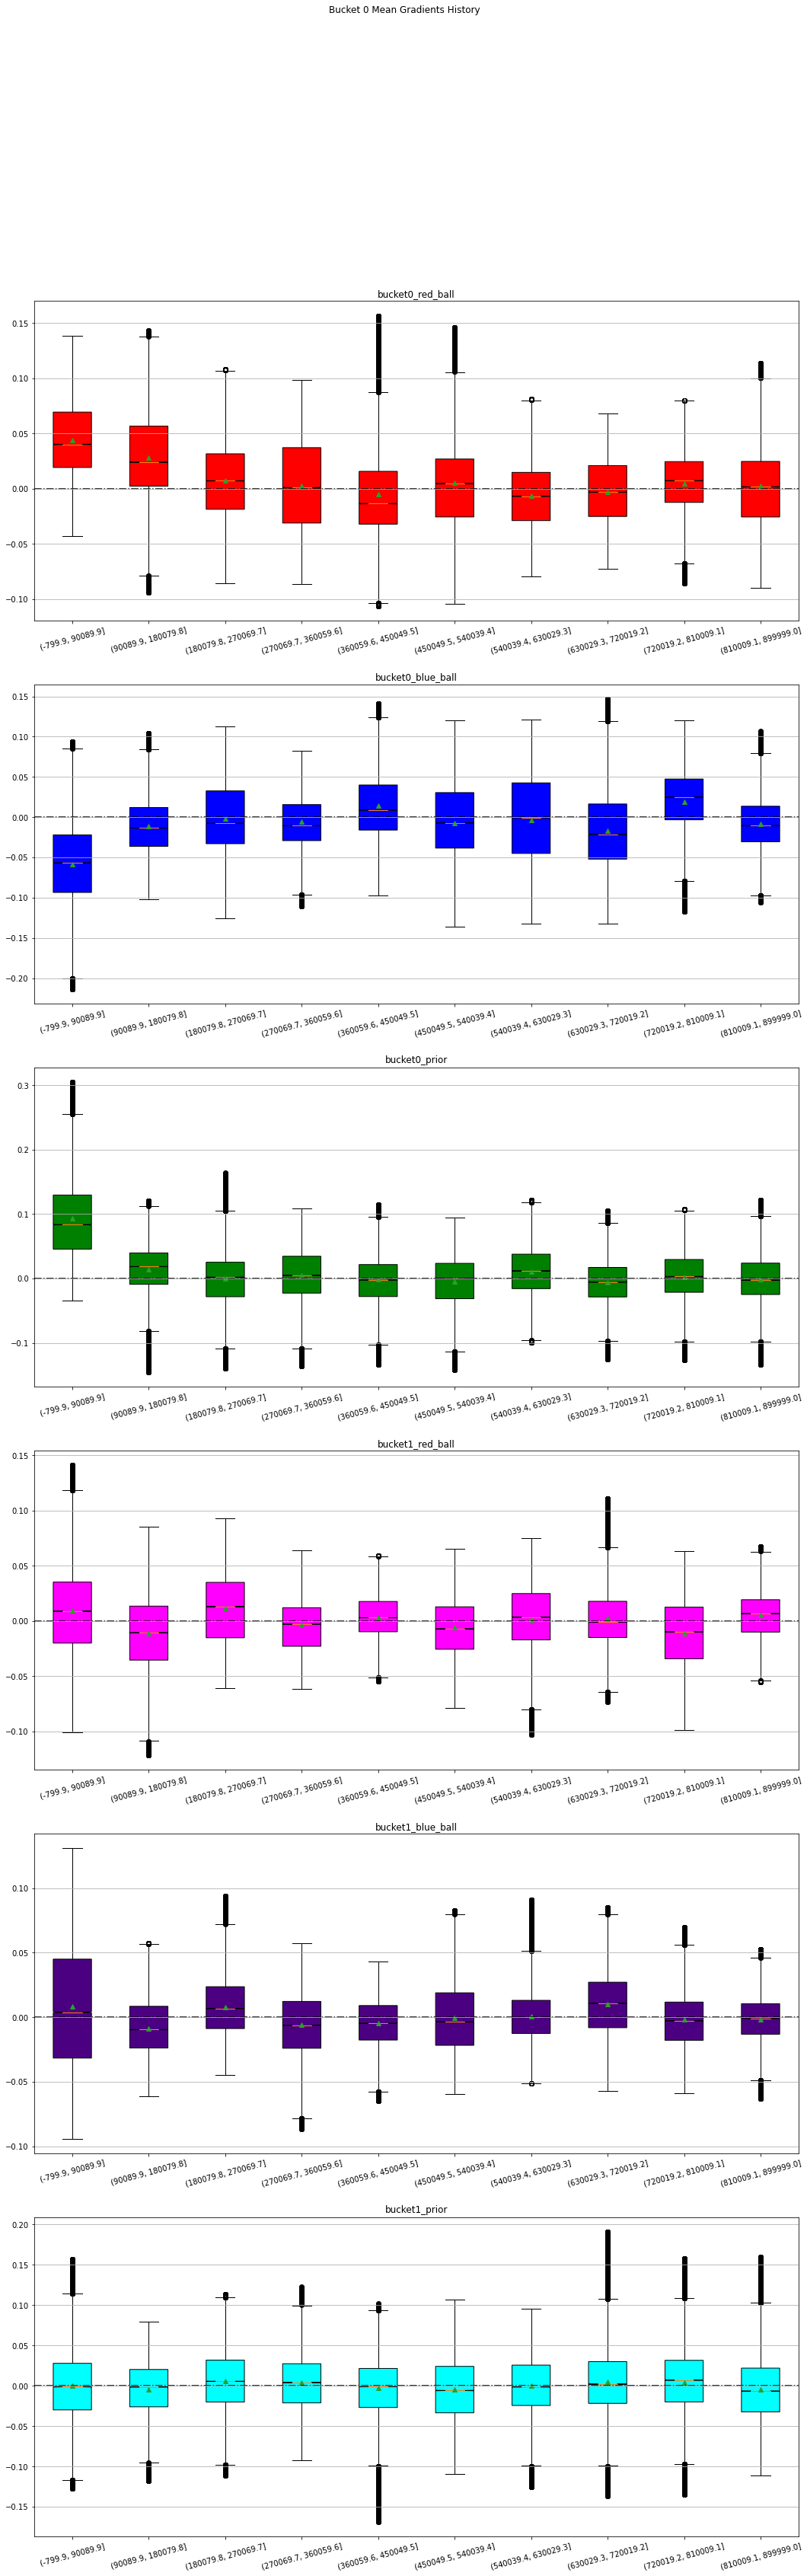

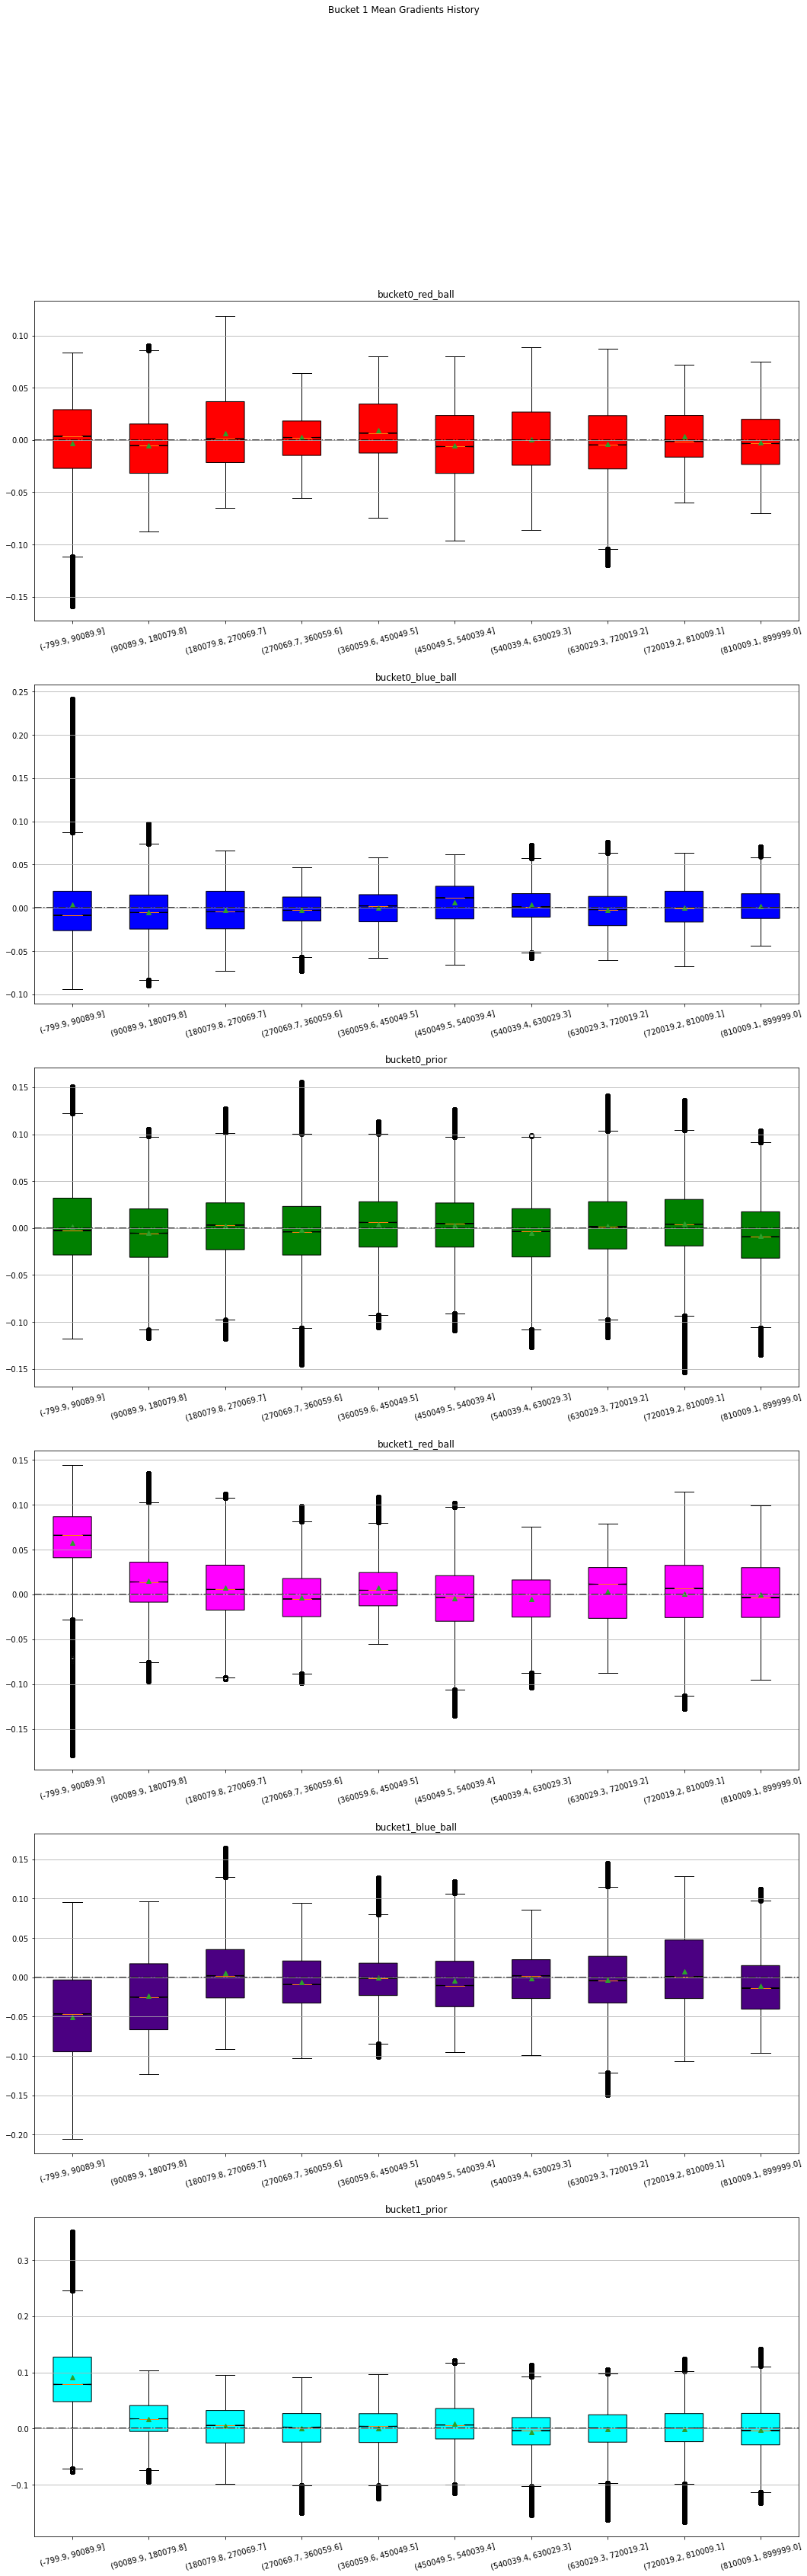

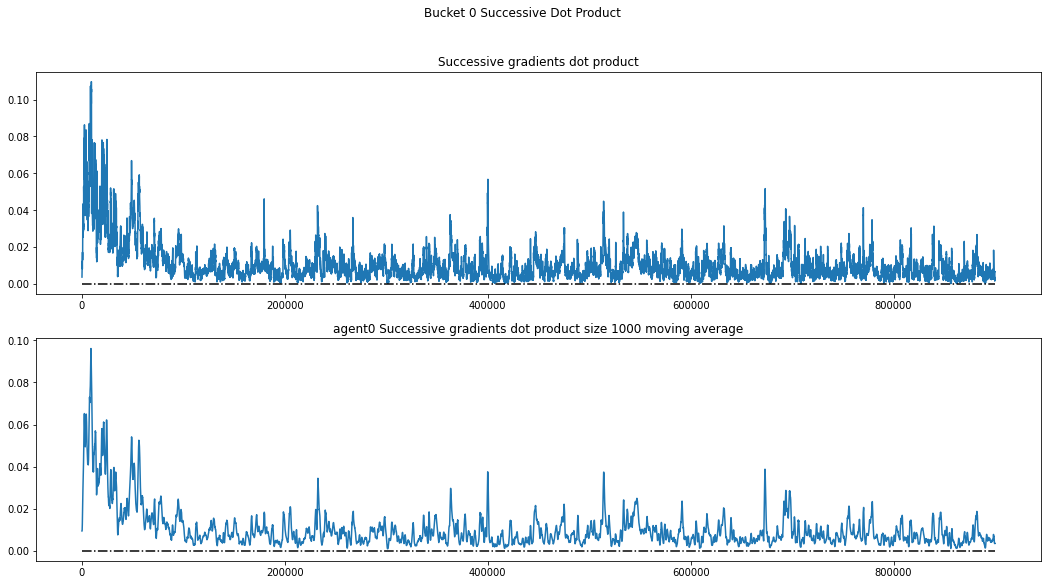

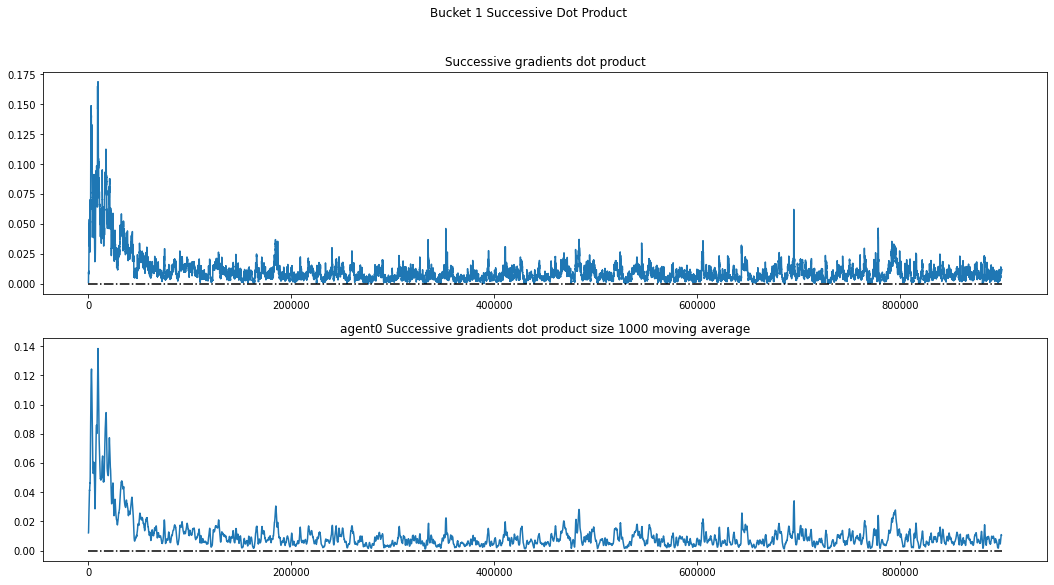

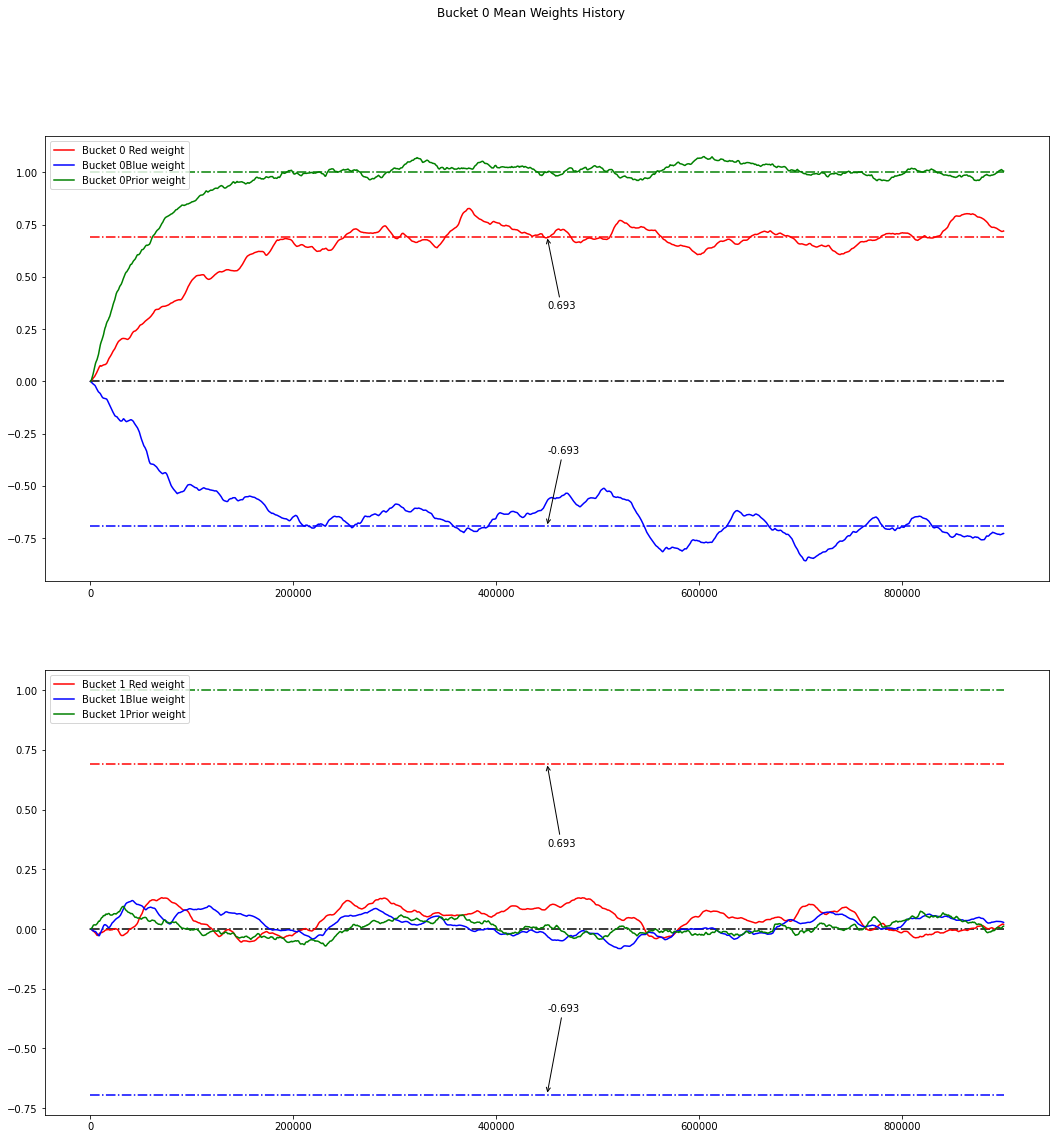

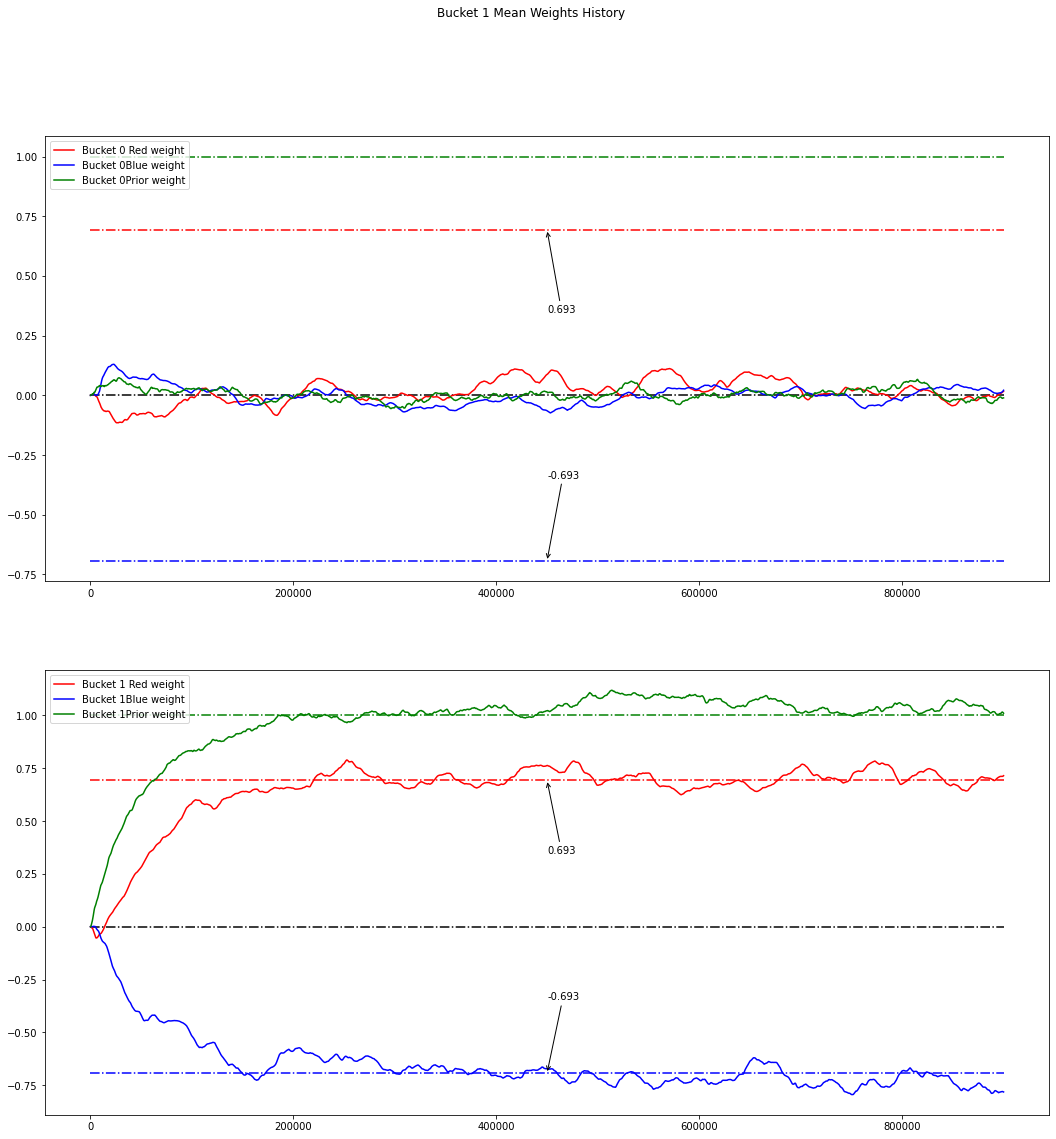

In [19]:
for agent in agent_list:
    agent.reward_history_plot()
    agent.mean_gradients_history_plot()
    agent.mean_gradients_successive_dot_product_plot()
#     agent.mean_history_plot()
    agent.mean_weights_history_plot()